# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [147]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable
from ipywidgets import interact

pd.options.mode.copy_on_write = True

In [149]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [150]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )



RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [151]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 6 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [152]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [153]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


In [154]:
import pandas as pd
import re
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output

In [155]:

def filter_comedy_movies(movie_df):
    """
    Filters comedy movies and their sequels based on specific conditions.
    
    Parameters:
        movie_df (pd.DataFrame): Input DataFrame with movie data.
        
    Returns:
        pd.DataFrame: Filtered DataFrame.
        set: Set of retained base IDs.
    """
    # Filter for comedy genre
    df_comedy = movie_df[movie_df['genre'].str.contains('comedy', case=False, na=False)]
    df_titles_ratings = df_comedy[['id', 'title', 'audienceScore', 'releaseDateStreaming']].copy()
    df_titles_ratings_sorted = (
        df_titles_ratings
        .sort_values(by='id', ascending=True)
        .reset_index(drop=True)
        .dropna(subset=['audienceScore'])
    )

    # Filter IDs ending with "_10" or "_[2-9]"
    df_ids_between_1_and_10 = df_titles_ratings_sorted[
        df_titles_ratings_sorted['id'].str.contains(r'_(10|[2-9])$', na=False)
    ]

    df_result = df_ids_between_1_and_10.copy()
    set_base = set()

    for full_id in df_ids_between_1_and_10['id']:
        if full_id.endswith("_2"):
            base_id_match = re.match(r'^(.*)_\d+$', full_id)
            if base_id_match:
                base_id = base_id_match.group(1)
                if not df_titles_ratings_sorted['id'].str.contains(f'^{base_id}$', na=False).any():
                    df_result = df_result[~df_result['id'].str.startswith(f'{base_id}_')]
                else:
                    if base_id in df_titles_ratings_sorted['id'].values:
                        set_base.add(base_id)
                        matching_record = df_titles_ratings_sorted[df_titles_ratings_sorted['id'] == base_id]
                        df_result = pd.concat([df_result, matching_record])

    set_base.discard('no_manches_frida')
    df_result = df_result.sort_values(by='id').reset_index(drop=True)

    return df_result, set_base


In [156]:
import re

def filter_dataframe(df, initial_bases):
    indices_to_drop = []  # Liste des indices à supprimer

    for i in df.index:
        full_id = df.loc[i, 'id']  # Récupérer l'ID complet pour la ligne courante
        last_char = full_id[-1]  # Dernier caractère
        before_last_char = full_id[-2] if len(full_id) > 1 else ""  # Avant-dernier caractère

        if last_char.isdigit() and before_last_char == "_":  # Vérifier si c'est une suite
            number = int(last_char)
            base = full_id[:-2]  # Supprimer "_x" pour obtenir la base

            if number == 2 and base not in initial_bases:
                indices_to_drop.append(i)
                continue

            if number > 2:
                # Vérifier si la base est dans `initial_bases`
                if base not in initial_bases:
                    indices_to_drop.append(i)
                    continue

                # Construire l'ID attendu pour "number-1"
                expected_previous_id = f"{base}_{number - 1}"  # Construire l'ID attendu
                if i == 0 or df.loc[i - 1, 'id'] != expected_previous_id:  # Vérifier si n-1 existe
                    indices_to_drop.append(i)
        else:  # Si ce n'est pas une suite, c'est une base
            if full_id not in initial_bases:  # Vérifier si la base est dans `initial_bases`
                indices_to_drop.append(i)

    # Supprimer les lignes avec les indices accumulés
    df.drop(index=indices_to_drop, inplace=True)

    # Réinitialiser les index pour un DataFrame propre
    df.reset_index(drop=True, inplace=True)

    return df


In [157]:
# Fonction modifiée pour extraire le base_id et le numéro de la séquelle
def extract_base_and_sequel(id_str):
    # Vérifie si le dernier caractère est un chiffre et l'avant-dernier est "_"
    if len(id_str) > 2 and id_str[-1].isdigit() and id_str[-2] == "_":
        base_id = id_str[:-2]  # Tout sauf les deux derniers caractères
        sequel_number = int(id_str[-1])  # Dernier caractère comme numéro
    else:
        base_id = id_str  # Tout l'ID est le nom de base
        sequel_number = 1  # Si pas une séquelle, on considère comme base
    return pd.Series([base_id, sequel_number], index=["base_id", "sequel_number"])


In [158]:
def data_part_1(movie_df):

    df_result, set_base = filter_comedy_movies(movie_df)
    
    final_df = filter_dataframe(df_result, set_base)
    # Appliquer la fonction et créer un nouveau DataFrame
    df_with_sequels = final_df.copy()
    df_with_sequels[["base_id", "sequel_number"]] = df_with_sequels["id"].apply(extract_base_and_sequel)



    set_titles = set(final_df[final_df['id'].isin(set_base)]['title'])
    
    return df_with_sequels, set_titles




In [159]:
final_df, set_titles = data_part_1(MASSIVE_RT_MOVIE_DS.df)


C:\Users\Caroline V\AppData\Local\Temp\ipykernel_5680\117398216.py:24: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [160]:
final_df.head(20)

,id,title,audienceScore,releaseDateStreaming,base_id,sequel_number
0,a_haunted_house,A Haunted House,51.0,2013-04-23,a_haunted_house,1
1,a_haunted_house_2,A Haunted House 2,43.0,2013-04-23,a_haunted_house,2
2,american_pie,American Pie,61.0,2003-07-29,american_pie,1
3,american_pie_2,American Pie 2,68.0,2002-01-15,american_pie,2
4,american_psycho,American Psycho,85.0,2005-06-21,american_psycho,1
5,american_psycho_2,American Psycho II: All American Girl,18.0,2002-06-18,american_psycho,2
6,back_to_the_future,Back to the Future,94.0,2010-08-17,back_to_the_future,1
7,back_to_the_future_2,Back to the Future Part II,85.0,2010-08-17,back_to_the_future,2
8,back_to_the_future_3,Back to the Future Part III,78.0,2010-08-17,back_to_the_future,3
9,bad_santa,Bad Santa,75.0,2004-06-22,bad_santa,1


In [161]:
pd.set_option('display.max_rows', 200)

In [162]:
# Fonction pour tracer le graphique interactif
def plot_movie_suites(selected_title):
    # Effacer la sortie précédente pour éviter les graphiques multiples
    clear_output(wait=True)
    
    # Récupérer l'ID de base correspondant au titre sélectionné
    base_row = final_df[final_df['title'] == selected_title]
    if base_row.empty:
        print(f"Movie title '{selected_title}' not found in the dataset.")
        return
    
    base_id = base_row.iloc[0]['base_id']  # Récupérer le base_id
    
    # Filtrer les suites basées sur le même base_id
    filtered_df = final_df[final_df['base_id'] == base_id].copy()
    if filtered_df.empty:
        print(f"No sequels found for '{selected_title}' in the dataset.")
        return
    
    # Trier par sequel_number pour garantir l'ordre logique
    filtered_df = filtered_df.sort_values(by="sequel_number")
    
    # Afficher le DataFrame filtré
    print("Filtered DataFrame:")
    print(filtered_df)
    
    # Ajouter une colonne "year" extraite de "releaseDateStreaming"
    filtered_df['year'] = pd.to_datetime(filtered_df['releaseDateStreaming'], errors='coerce').dt.year
    
    # Vérifier si des années valides existent
    valid_filtered_df = filtered_df.dropna(subset=['year'])
    
    # Créer le graphique
    fig = go.Figure()
    if valid_filtered_df.empty:
        print(f"No valid release dates for '{selected_title}', but audience scores will be shown.")
    
    # Utiliser les années si disponibles, sinon les titres uniquement
    x_labels = (
        valid_filtered_df['title'] + " (" + valid_filtered_df['year'].astype(int).astype(str) + ")"
        if not valid_filtered_df.empty
        else filtered_df['title']
    )
    
    fig.add_trace(go.Scatter(
        x=x_labels,
        y=filtered_df['audienceScore'],  # Scores des spectateurs
        mode='lines+markers',
        name=selected_title,
        line=dict(color='royalblue', width=3),
        marker=dict(size=10, color='orange', line=dict(width=2, color='darkblue'))
    ))
    
    # Ajouter des annotations pour chaque score
    for i, row in filtered_df.iterrows():
        label = (
            row['title'] + f" ({int(row['year'])})" if pd.notna(row['year']) else row['title']
        )
        fig.add_annotation(
            x=label,
            y=row['audienceScore'],
            text=str(int(row['audienceScore'])),
            showarrow=False,
            font=dict(size=12, color="black"),
            bgcolor="lightyellow",
            bordercolor="black"
        )
    
    # Ajouter les labels et le style
    fig.update_layout(
        title=dict(
            text=f"<b>Audience Scores for '{selected_title}' and Its Sequels</b>",
            font=dict(size=18, color="darkblue"),
            x=0.5
        ),
        xaxis=dict(
            title="Movie Titles (Release Year if available)",
            titlefont=dict(size=14, color="darkblue"),
            tickangle=45,
            tickfont=dict(size=12, color="black")
        ),
        yaxis=dict(
            title="Audience Score",
            titlefont=dict(size=14, color="darkblue"),
            tickfont=dict(size=12, color="black"),
            gridcolor="lightgrey"
        ),
        plot_bgcolor="whitesmoke",
        template="plotly_white"
    )
    
    # Afficher le graphique
    display(fig)

# Widget interactif avec les titres dans set_titles
interact(plot_movie_suites, selected_title=sorted(list(set_titles)))


interactive(children=(Dropdown(description='selected_title', options=('A Haunted House', 'American Pie', 'Amer…

<function __main__.plot_movie_suites(selected_title)>

In [163]:
final_df.head()

,id,title,audienceScore,releaseDateStreaming,base_id,sequel_number
0,a_haunted_house,A Haunted House,51.0,2013-04-23,a_haunted_house,1
1,a_haunted_house_2,A Haunted House 2,43.0,2013-04-23,a_haunted_house,2
2,american_pie,American Pie,61.0,2003-07-29,american_pie,1
3,american_pie_2,American Pie 2,68.0,2002-01-15,american_pie,2
4,american_psycho,American Psycho,85.0,2005-06-21,american_psycho,1


In [164]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sequel_ratings(df):
    """
    Produces a scatter plot showing the relationship between sequel number and average audience score.
    The size of the points reflects the number of movies in each sequel.

    Args:
        df (pd.DataFrame): DataFrame containing the columns 'sequel_number' and 'audienceScore'.
    """
    # Create a copy of the DataFrame
    df = df.copy()

    # Check if the required columns are present
    required_columns = {"sequel_number", "audienceScore"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Group by sequel_number to calculate averages and counts
    grouped = df.groupby("sequel_number").agg(
        avg_audienceScore=("audienceScore", "mean"),
        film_count=("audienceScore", "size")
    ).reset_index()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        grouped["sequel_number"],
        grouped["avg_audienceScore"],
        s=grouped["film_count"] * 50,  # Adjust the multiplier for point size
        alpha=0.7,
        color="blue"
    )

    # Add labels for the number of movies
    for i in range(len(grouped)):
        plt.text(
            grouped["sequel_number"][i],
            grouped["avg_audienceScore"][i] + 1,  # Offset for readability
            f'{grouped["film_count"][i]} films',
            ha="center"
        )

    # Set integer ticks on the x-axis
    plt.xticks(ticks=range(grouped["sequel_number"].min(), grouped["sequel_number"].max() + 1))

    # Additional plot configurations
    plt.title("Relationship Between Sequel Number and Average Audience Score", fontsize=14)
    plt.xlabel("Sequel Number", fontsize=12)
    plt.ylabel("Average Audience Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


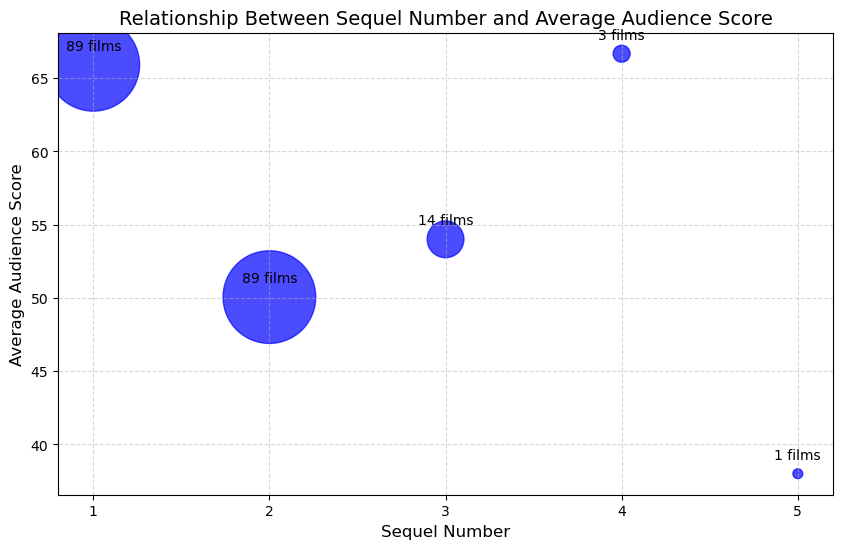

In [165]:
plot_sequel_ratings(df_with_sequels)

## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

## I- Popularity analysis

##

## II. Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


## III. Per-genre analysis 

As this section neither requires any additional datasets, nor does it use any different type of techniques, we do no provide a sample Proof of Concept for it. The final analysis will be ready for P3! 

## IV. Cultural differences